In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy
import matplotlib.pyplot as plt

/global/home/users/tsautory/.conda/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from train_script import ChannelFlow
from torch.utils.data import DataLoader, Dataset

In [4]:
# model name
# model_name = 'weighted_boundary_unet_channelinit16'
model_name = 'standardized_test'

# datasets
train_dataset = ChannelFlow(dataset='train', data_path='example8/')
val_dataset = ChannelFlow(dataset='val', data_path='example8/')

In [5]:
from cnn_models import ConvUNet

In [6]:
reshape_size = 16
model = ConvUNet(input_size=reshape_size, channels_init=16)
checkpoint = torch.load('trainings/saved_models/' + model_name)
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [7]:
device='cpu'
dtype = torch.float32

In [8]:
model.eval()
batch_size = 25
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [9]:
# for i, (x_sample, y_sample, flow_sample) in enumerate(val_dataloader):
#     x_sample = x_sample.to(device=device, dtype=dtype)
#     y_sample = y_sample.to(device=device, dtype=dtype)
#     flow_sample = flow_sample.to(device=device, dtype=dtype) # move to device, e.g. GPU
#     reconstruction = model.forward(torch.cat([x_sample, y_sample, flow_sample], axis=1))
#     break

In [21]:
def normalize(tens):
    means = tens.mean(dim=(-1, -2), keepdim=True)
    stds = tens.std(dim=(-1, -2), keepdim=True)
    tens_norm = (tens - means) / stds
    return tens_norm, means, stds

In [22]:
x_sample, y_sample, flow_sample = next(iter(val_dataloader))
x_sample = x_sample.to(device=device, dtype=dtype)
y_sample = y_sample.to(device=device, dtype=dtype)
flow_sample = flow_sample.to(device=device, dtype=dtype) # move to device, e.g. GPU

In [23]:
x_sample_norm, _, _ = normalize(x_sample)
y_sample_norm, _, _ = normalize(y_sample)
flow_sample_norm, means, stds = normalize(flow_sample)

reconstruction_norm = model.forward(torch.cat([x_sample_norm, y_sample_norm, flow_sample_norm], axis=1))
reconstruction = reconstruction_norm * stds + means

Text(0.5, 0.98, 'Output fields')

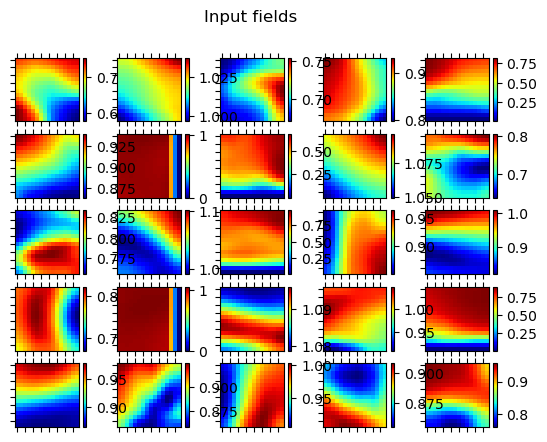

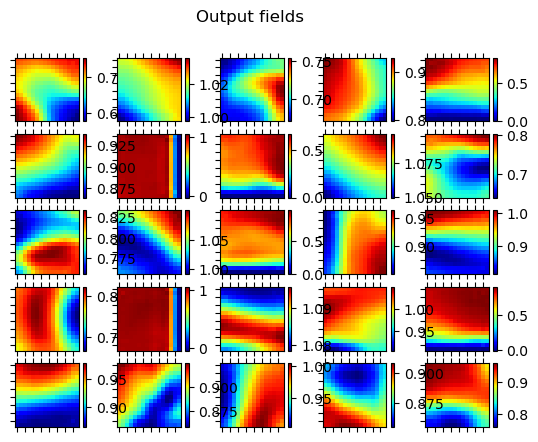

In [24]:
ni=5
nj=5

fig1, axs1 = plt.subplots(ni, nj)
fig2, axs2 = plt.subplots(ni, nj)

for i in range(ni):
    for j in range(nj):
        idx = nj*i + j
        
        c = axs1[i, j].matshow(flow_sample[idx, 0].detach().numpy(), cmap = plt.cm.jet)
        fig1.colorbar(c, ax = axs1[i, j])

        plt.setp(axs1[i, j].get_xticklabels(), visible = False)
        plt.setp(axs1[i, j].get_yticklabels(), visible = False)

        c = axs2[i, j].matshow(reconstruction[idx, 0].detach().numpy(), cmap = plt.cm.jet)
        fig2.colorbar(c, ax = axs2[i, j])

        plt.setp(axs2[i, j].get_xticklabels(), visible = False)
        plt.setp(axs2[i, j].get_yticklabels(), visible = False)
        
fig1.suptitle('Input fields')
fig2.suptitle('Output fields')